In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"  # adjust for your machine and availability
import jax

os.listdir()
os.chdir("..")
from src.c3po.model.model import C3PO
from src.c3po.toy_model_generators.hmm import generate_hmm_spike_train

# Simulated Data

In [60]:
t = np.arange(0, 3000)
mark_ids, mark_times, marks, template_waveforms, firing_rates, hmm_sequence = (
    generate_hmm_spike_train(
        t=t,
        noise_scale=0.1,
        peak_rng=(0.3, 1),
        soft_binarize_firing_rate=True,
        n_units=30,
        firing_rate_rng=(1e-3, 1),
    )
)


relative_rates = firing_rates[:, 0] / firing_rates[:, 1]
ind_sort = np.argsort(relative_rates)

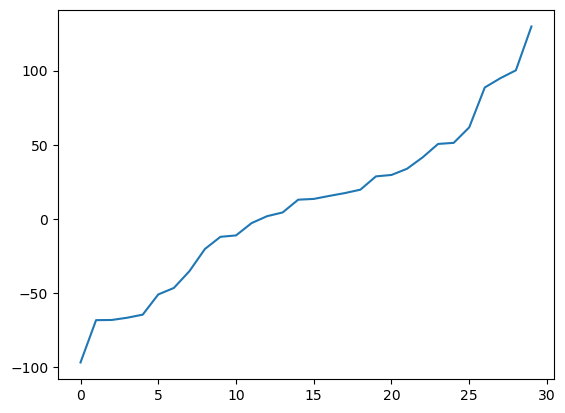

In [61]:
plt.plot(np.log2(relative_rates)[ind_sort])

# Train

### Define Model and Training Data

In [70]:
# prep data for model
from src.c3po.model.util import prep_training_data

delta_t = np.diff(mark_times)[None, ...]
x = marks[1:][None, ...]

sample_length = 2000
x_train, delta_t_train = prep_training_data(x, delta_t, sample_length)
i = sample_length

# hyperparams
latent_dim = 4
context_dim = 2
encoder_widths = [32, 16, 8]

n_neg_samples = 4
encoder_args = dict(encoder_model="simple", widths=encoder_widths)
dilations = [
    1,
    2,
    4,
    8,
]
kernels = [8, 8, 16, 16]
context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,  # [1, 2, 3, 5, 7, 9, 17, 21, 1, 2, 3, 5, 7, 9, 17, 21],
    layer_kernel_size=kernels,
    expanded_dim=64,
    smoothing=2,
    smoothing_decay=1,
    categorical=False,
)


rate_args = dict(
    rate_model="bilinear",
)


# model = C3PO(encoder_args, context_args, rate_args, latent_dim, context_dim, n_neg_samples)
model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution="poisson",
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=1,
    return_embeddings_in_call=True,
)

rand_key = jax.random.PRNGKey(0)
params = model.init(jax.random.PRNGKey(0), x, delta_t, rand_key)
run_model = jax.jit(model.apply)
x_train.shape

3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
z_stacked (1, 1, 44859, 4)
Z (1, 44860, 4) pos_params (1, 1, 44859, 1)
neg_z (1, 4, 44860, 4)
c (1, 44860, 2)
neg_params (1, 4, 44859, 1)


(43, 2000, 32)

### Run optimization

In [ ]:
import optax
from tqdm import tqdm
from src.c3po.model.model import loss

learning_rate = 1e-3
batch_size = 16


def training_loss_fun(params, x, delta_t, rand_key):
    pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
    return model.contrastive_loss(
        pos_params,
        neg_params,
        delta_t,
        z[:, 1:],
        neg_z,
    )


loss_grad_fn = jax.value_and_grad(training_loss_fun)


optimizer = optax.chain(
    # optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate),
)

# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(params)
# Run training loop.
tracked_loss = []
with tqdm() as pbar:
    for i in range(1000):
        ind = np.arange(x_train.shape[0])
        np.random.shuffle(ind)
        epoch_loss = []
        j = 0
        while j < x_train.shape[0]:
            # Perform one gradient update.
            rand_key, _ = jax.random.split(rand_key)
            batch_inds = ind[j : j + batch_size]
            loss_val, grads = loss_grad_fn(
                params, x_train[batch_inds], delta_t_train[batch_inds], rand_key
            )
            epoch_loss.append(loss_val)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            j += batch_size
        tracked_loss.append(np.mean(epoch_loss))
        pbar.update(1)
        pbar.set_description(f"loss: {tracked_loss[-1]:.4f}")

0it [00:00, ?it/s]

z_stacked (16, 1, 1999, 4)
Z (16, 2000, 4) pos_params (16, 1, 1999, 1)
neg_z (16, 4, 2000, 4)
c (16, 2000, 2)
neg_params (16, 4, 1999, 1)
z_stacked (11, 1, 1999, 4)
Z (11, 2000, 4) pos_params (11, 1, 1999, 1)
neg_z (11, 4, 2000, 4)
c (11, 2000, 2)
neg_params (11, 4, 1999, 1)


loss: 1.0620: : 1000it [04:58,  3.35it/s]


Text(0, 0.5, 'Loss')

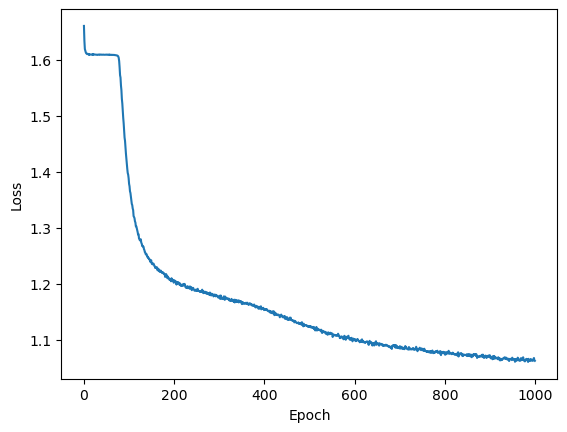

In [72]:
epoch = np.arange(len(tracked_loss))
plt.plot(epoch, tracked_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Generate and Look at results

In [73]:
pos_rates, cum_neg_rates, z, c, neg = run_model(
    params, x_train, delta_t_train, rand_key
)
pos_rates.shape

z_stacked (43, 1, 1999, 4)
Z (43, 2000, 4) pos_params (43, 1, 1999, 1)
neg_z (43, 4, 2000, 4)
c (43, 2000, 2)
neg_params (43, 4, 1999, 1)


(43, 1, 1999, 1)

In [74]:
from src.c3po.model.model import Embedding

embedding_params = {
    "params": params["params"]["embedding"],
    # "state": params["state"]["embedding"],
}

z, c = Embedding(encoder_args, context_args, latent_dim, context_dim).apply(
    embedding_params, x, delta_t
)


c = np.array(c)

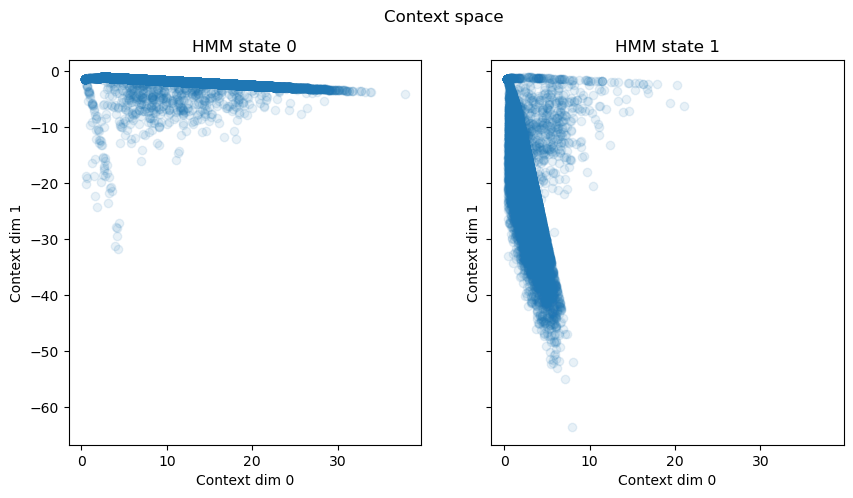

In [75]:
mark_ind = np.digitize(mark_times[1:], t)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
include = hmm_sequence[mark_ind, 0].astype(bool)
ax[0].scatter(c[0, include, 0], c[0, include, 1], alpha=0.1)
ax[1].scatter(c[0, ~include, 0], c[0, ~include, 1], alpha=0.1)

fig.suptitle("Context space")
ax[0].set_title("HMM state 0")
ax[1].set_title("HMM state 1")

for a in ax:
    a.set_xlabel("Context dim 0")
    a.set_ylabel("Context dim 1")

Text(0.5, 0, 'Time (s)')

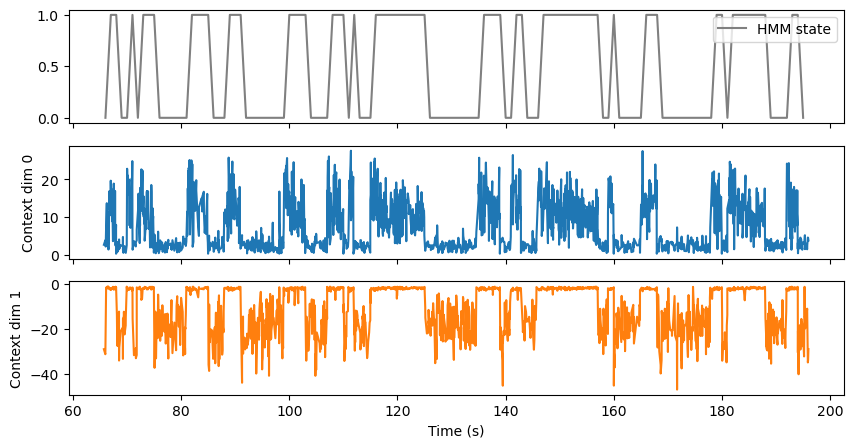

In [76]:
plot_slice = slice(1000, 3000)
fig, ax = plt.subplots(nrows=context_dim + 1, figsize=(10, 5), sharex=True)

for i, a in enumerate(ax[1:]):
    # a.scatter(mark_times[plot_slice],c[0, plot_slice, i],s=50,alpha=.7)
    a.plot(mark_times[plot_slice], c[0, plot_slice, i], c=plt.cm.tab10(i))
    t_max = mark_times[plot_slice].max()
    # ind_plot = np.where(t < t_max)[0][-1]
    prop_cycle = plt.rcParams["axes.prop_cycle"]
    colors = prop_cycle.by_key()["color"]
    a.set_ylabel(f"Context dim {i}")
ind_plot = np.logical_and(t < t_max, t > mark_times[plot_slice].min())
ax[0].plot(t[ind_plot], hmm_sequence[ind_plot, 0], label="HMM state", c="grey")
ax[0].legend(loc="upper right")
ax[-1].set_xlabel("Time (s)")

# fig, ax = plt.subplots(nrows=context_dim, figsize=(10, 5), sharex=True)
# for i,a in enumerate(ax):
#     a.plot(c[0, plot_slice, i])
#     # a.plot(hmm_sequence[mark_ind, 0][plot_slice], zorder=-1,label="HMM state")
#     # t_max = mark_times[plot_slice].max()
#     # ind_plot = np.where(t < t_max)[0][-1]
#     a.plot(hmm_sequence[:ind_plot, 0][plot_slice], label="HMM state")
#     a.set_ylabel(f"Context dim {i}")
# ax[0].legend(loc="upper right")

In [77]:
relative_rates = firing_rates[:, 0] / firing_rates[:, 1]
relative_rates = np.log10(relative_rates)
relative_rates

rate_color = np.clip(
    (relative_rates - relative_rates.min())
    / (relative_rates.max() - relative_rates.min()),
    0,
    1,
)
rate_color = plt.cm.PRGn(rate_color)

Text(0.5, 1.0, 'HMM state 1')

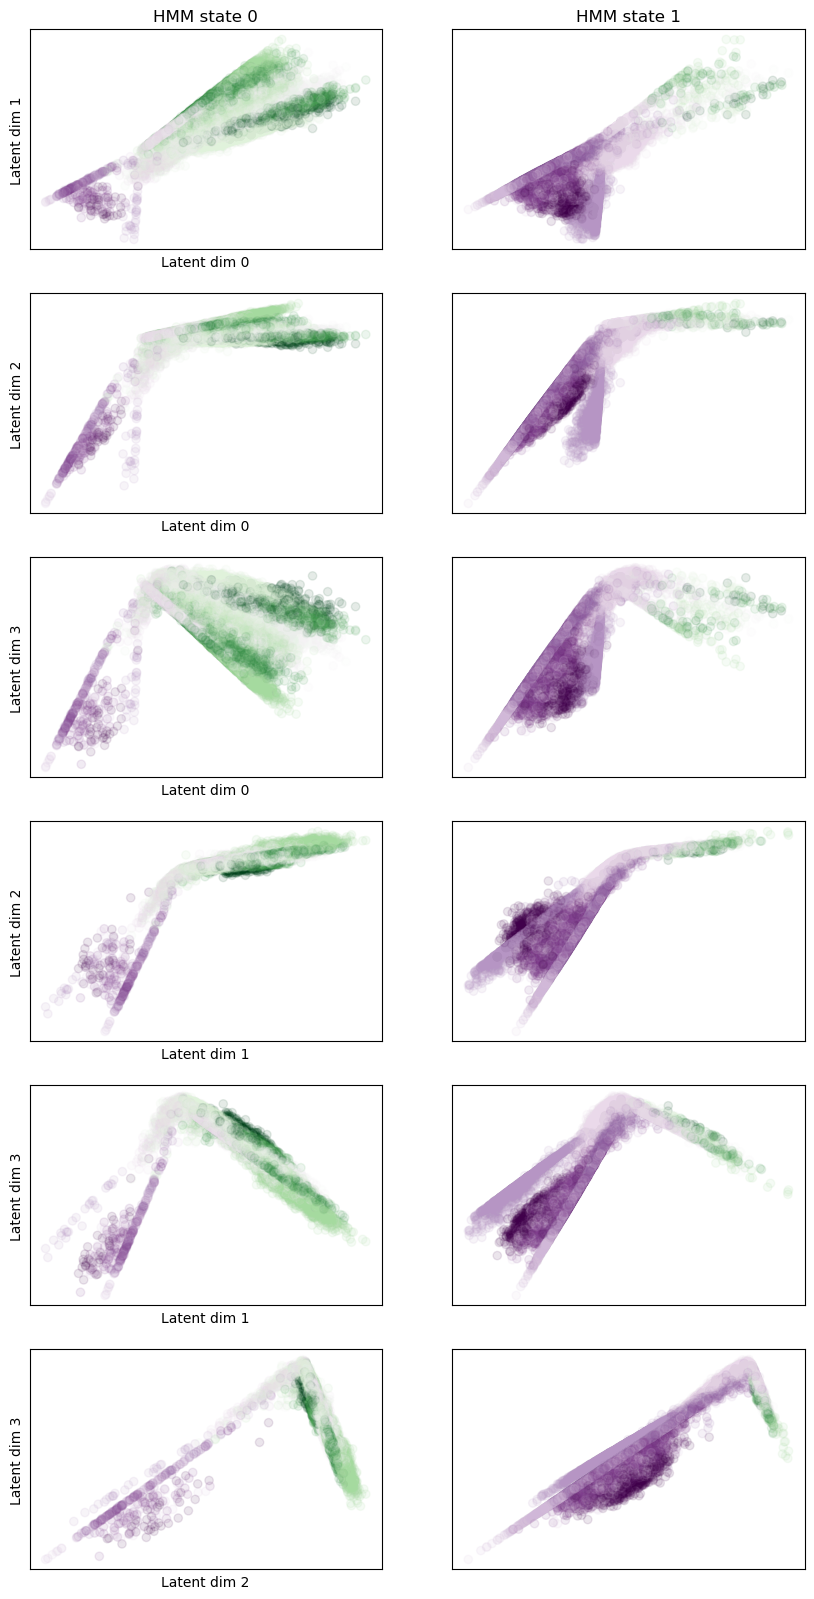

In [78]:
import math

mark_ind = np.digitize(mark_times[1:], t)

fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(10, 20))
include = hmm_sequence[mark_ind, 0].astype(bool)

ax_loc = 0
for i in range(latent_dim):
    for j in range(i + 1, latent_dim):
        ax[ax_loc, 0].scatter(
            z[0, include, i],
            z[0, include, j],
            alpha=0.1,
            #  c=plt.cm.jet(mark_ids[1:][include]/mark_ids.max()),
            c=rate_color[mark_ids[1:][include]],
        )
        ax[ax_loc, 1].scatter(
            z[0, ~include, i],
            z[0, ~include, j],
            alpha=0.1,
            # c=plt.cm.jet(mark_ids[1:][~include] / mark_ids.max()),
            c=rate_color[mark_ids[1:][~include]],
        )
        ax[ax_loc, 0].set_xlabel(f"Latent dim {i}")
        ax[ax_loc, 0].set_ylabel(f"Latent dim {j}")
        ax_loc += 1

    # break

for a in np.ravel(ax):
    a.set_xticks([])
    a.set_yticks([])
ax[0, 0].set_title("HMM state 0")
ax[0, 1].set_title("HMM state 1")
# ax[0,0].scatter(z[0, include, 1], z[0, include, 2], alpha=0.1)
# ax[0,1].scatter(z[0, ~include, 1], z[0, ~include, 2], alpha=0.1)

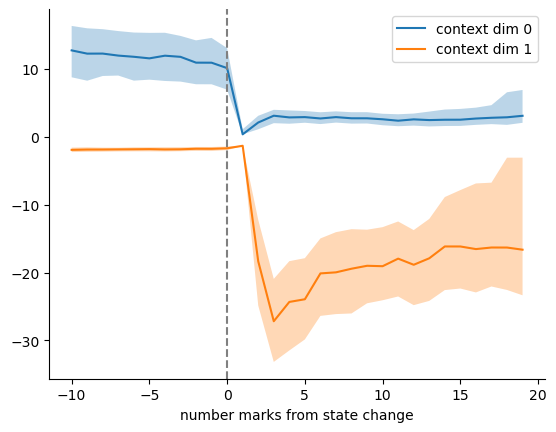

In [80]:
mark_ind = np.digitize(mark_times[1:], t)

# fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
fig = plt.figure()
ax = fig.gca()

ax.spines[["top", "right"]].set_visible(False)
mark_state = hmm_sequence[mark_ind, 0]  # .astype(bool)

enter = np.where(np.diff(mark_state) == -1)[0]

val = []
for i in enter:
    val.append(c[0, i - 10 : i + 20, :])

val = np.array(val)
xx = np.arange(val.shape[1]) - 10
for i in range(val.shape[-1]):
    plt.plot(xx, np.median(val[:, :, i], axis=0), label=f"context dim {i}")
    plt.fill_between(
        xx,
        np.percentile(val[:, :, i], 25, axis=0),
        np.percentile(val[:, :, i], 75, axis=0),
        alpha=0.3,
    )

plt.axvline(0, c="grey", ls="--")

plt.xlabel("number marks from state change")
plt.legend()

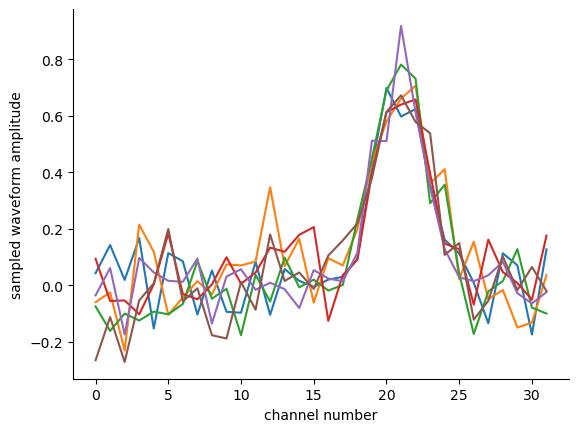

In [19]:
loc = np.where(mark_ids == 1)[0]
fig = plt.figure()
ax = fig.gca()
marks[loc].shape

plt.plot(marks[loc][:6].T)
plt.xlabel("channel number")
plt.ylabel("sampled waveform amplitude")
ax.spines[["top", "right"]].set_visible(False)